### Imports

In [1]:
import netCDF4 as nc
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from geopy.distance import distance
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
import datetime
from matplotlib.ticker import AutoMinorLocator

### Loading relevant data

In [2]:
path = "01-EarthCARE/ECA_EXAA_ATL_FM__2A_20241231T183450Z_20230131T101420Z_39316D/"
filename = "ECA_EXAA_ATL_FM__2A_20241231T183450Z_20230131T101420Z_39316D.h5"
data = nc.Dataset(path+filename, "r", format="hdf5")

science_data = data.groups["ScienceData"]
lat = science_data["latitude"][:]
lon = science_data["longitude"][:]
fmask = science_data["featuremask"][:]
time = science_data["time"][:]
height = science_data["height"][:]
data.close()

### Filtering data for 1000km radius around Halifax

In [3]:
# Calculating geodesic (WGS-84) distance from Halifax using geopy
halifax = (44.6,-63.6)
halifax_dist = lambda lat,lon: distance((lat,lon),halifax).kilometers
halifax_distv = np.vectorize(halifax_dist)

# Creating masking array
halifax1000km = halifax_distv(lat,lon) <=1000

# Filtering data
filtered_fmask = fmask[halifax1000km,:]
filtered_time = time[halifax1000km]
filtered_height = height[halifax1000km]

### Creating a custom colormap

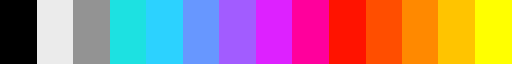

In [4]:
# clouds/aerosols colors
seq1 = matplotlib.colormaps["autumn"]
color_list_seq1 = seq1(np.linspace(0, 1, 5))
# clear sky colors
seq2 = matplotlib.colormaps["cool"]
color_list_seq2 = seq2(np.linspace(0, 1, 5))
# colors for categorical values
color_list_cat = colors.to_rgba_array(["black", "white", "gray"])

# assemble list and create colormap
color_list = np.concatenate([color_list_cat,color_list_seq2,color_list_seq1])
cmap_name = "custom_disc"
discrete_map = LinearSegmentedColormap.from_list(cmap_name, color_list, 14)
discrete_map

### Formatting time data

In [5]:
# converting from elapsed seconds to datetime strings
start_time = datetime.datetime(2000,1,1)
time_formatted = np.atleast_2d([start_time + datetime.timedelta(seconds=s) for s in filtered_time])

# converting from meters to kilometers
height_formatted = filtered_height / 1000

### Creating the figure

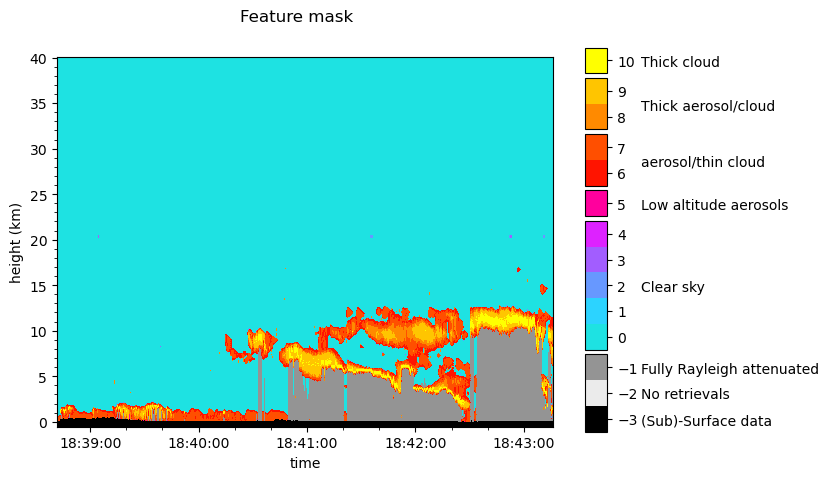

In [6]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
im = ax.pcolormesh(time_formatted,
                    height_formatted.T,
                    filtered_fmask.T,
                    cmap=discrete_map,
                    vmin=np.min(filtered_fmask),
                    vmax=np.max(filtered_fmask),
                    shading="nearest")

# axis labels
ax.set_xlabel("time")
ax.set_ylabel("height (km)")

# adjust tick density and minor ticks
ax.set_xticks(plt.xticks()[0][::2],plt.xticks()[1][::2])
ax.xaxis.set_minor_locator(AutoMinorLocator(3))

ax.set_yticks(np.arange(40),minor=True)

### Calculating spacings for colorbar(s)
low_end = 0.1                                   # this is the lower edge of the colorbar
high_end = 0.9                                  # this is the top of the colorbar
gap = 0.01                                      # spacing between subcolorbars
space_per_unit = (high_end-5*gap-low_end)/14    # space for one level of the featuremask

sec_label_pos = 2.3                             # position for class labels (clouds, aerosols, etc.)

### Creating axes for colorbar(s)
cb1ax = fig.add_axes([0.95, low_end+13*space_per_unit+5*gap, 0.035, 1*space_per_unit])
cb2ax = fig.add_axes([0.95, low_end+11*space_per_unit+4*gap, 0.035, 2*space_per_unit])
cb3ax = fig.add_axes([0.95, low_end+9*space_per_unit+3*gap, 0.035, 2*space_per_unit])
cb4ax = fig.add_axes([0.95, low_end+8*space_per_unit+2*gap, 0.035, 1*space_per_unit])
cb5ax = fig.add_axes([0.95, low_end+3*space_per_unit+gap, 0.035, 5*space_per_unit])
cb6ax = fig.add_axes([0.95, low_end, 0.035, 3*space_per_unit])

### Creating colorbars (separate colorbar for each class)
fig.colorbar(im, cax=cb1ax, boundaries=[9.5,10.5], ticks=[10])
# secondary axis only for class labels
sec1 = cb1ax.secondary_yaxis(location=sec_label_pos)
sec1.set_yticks([10], labels=["Thick cloud"])
# switch off everything but the label
sec1.tick_params('y', length=0)
sec1.spines['right'].set_visible(False)

fig.colorbar(im, cax=cb2ax, boundaries=np.linspace(7.5,9.5,3), ticks=[8,9])
# secondary axis only for class labels
sec2 = cb2ax.secondary_yaxis(location=sec_label_pos)
sec2.set_yticks([8.5], labels=["Thick aerosol/cloud"])
# switch off everything but the label
sec2.tick_params('y', length=0)
sec2.spines['right'].set_visible(False)

fig.colorbar(im, cax=cb3ax, boundaries=np.linspace(5.5,7.5,3), ticks=[6,7])
# secondary axis only for class labels
sec3 = cb3ax.secondary_yaxis(location=sec_label_pos)
sec3.set_yticks([6.5], labels=["aerosol/thin cloud"])
# switch off everything but the label
sec3.tick_params('y', length=0)
sec3.spines['right'].set_visible(False)

fig.colorbar(im, cax=cb4ax, boundaries=[4.5,5.5], ticks=[5])
# secondary axis only for class labels
sec4 = cb4ax.secondary_yaxis(location=sec_label_pos)
sec4.set_yticks([5], labels=["Low altitude aerosols"])
# switch off everything but the label
sec4.tick_params('y', length=0)
sec4.spines['right'].set_visible(False)

fig.colorbar(im, cax=cb5ax, boundaries=np.linspace(-0.5,4.5,6), ticks=[0,1,2,3,4])
# secondary axis only for class labels
sec5 = cb5ax.secondary_yaxis(location=sec_label_pos)
sec5.set_yticks([2], labels=["Clear sky"])
# switch off everything but the label
sec5.tick_params('y', length=0)
sec5.spines['right'].set_visible(False)

fig.colorbar(im, cax=cb6ax, boundaries=np.linspace(-3.5,-0.5,4), ticks=[-3,-2,-1])
# secondary axis only for class labels
sec6 = cb6ax.secondary_yaxis(location=sec_label_pos)
sec6.set_yticks([-3,-2,-1], labels=["(Sub)-Surface data", "No retrievals", "Fully Rayleigh attenuated"])
# switch off everything but the label
sec6.tick_params('y', length=0)
sec6.spines['right'].set_visible(False)

fig.suptitle("Feature mask")

plt.show()